In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers datasets scikit-learn torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
# 步骤3：导入模块
import os
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
# os.environ['WANDB_API_KEY'] = '255fab36462f5587d825c69b9d5b53a852a2c4d3'  # 替换为你的实际 API 密钥
os.environ['WANDB_MODE'] = 'disabled'

# 步骤4：配置路径
DRIVE_DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/data'
file_paths = {
    'train': os.path.join(DRIVE_DATA_PATH, 'imdb_train.npz'),
    'test': os.path.join(DRIVE_DATA_PATH, 'imdb_test.npz'),
    'val': os.path.join(DRIVE_DATA_PATH, 'imdb_val.npz')
}

# 步骤5：加载数据
def load_npz(file_path):
    data = np.load(file_path)
    return data['x'], data['y']

# 加载数据集
train_texts, train_labels = load_npz(file_paths['train'])
val_texts, val_labels = load_npz(file_paths['val'])
test_texts, test_labels = load_npz(file_paths['test'])

# 新增：打印数据集大小
print(f"Conjunto de entrenamiento: {len(train_texts)} | Conjunto de validación: {len(val_texts)} | Conjunto de prueba: {len(test_texts)}")

Conjunto de entrenamiento: 20000 | Conjunto de validación: 5000 | Conjunto de prueba: 25000


In [3]:
# 步骤6：数据预处理（修复格式问题）
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess(texts, labels):
    texts = [str(text) for text in texts]  # 确保文本是字符串
    encodings = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )
    # 将标签转换为张量并合并到encodings字典中
    encodings['labels'] = torch.tensor(labels)
    return encodings

# 转换为PyTorch Dataset
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.encodings = preprocess(texts, labels)

    def __getitem__(self, idx):
        # 返回单个样本的字典格式
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.encodings['labels'][idx]
        }

    def __len__(self):
        return len(self.encodings['labels'])

# 重新初始化数据集
train_dataset = IMDbDataset(train_texts, train_labels)
val_dataset = IMDbDataset(val_texts, val_labels)
test_dataset = IMDbDataset(test_texts, test_labels)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [4]:
# 步骤7：模型配置
model_save_path = "/content/drive/MyDrive/Colab Notebooks/model/imdb"
os.makedirs(model_save_path, exist_ok=True)


# 自动检测设备（优先GPU，否则CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化新模型（每次运行都会从头载入预训练权重）
print("Inicializando un nuevo modelo...")
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    attention_probs_dropout_prob=0.1  # 你可以调整这个 Dropout 值
).to(device)

# 显式验证设备
print(f"Modelo cargado en: {device}")

Inicializando un nuevo modelo...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelo cargado en: cuda


In [5]:
# 步骤8：训练配置
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/data",
    eval_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir=os.path.join(DRIVE_DATA_PATH, 'logs'),
    logging_steps=100
)

# 步骤9：定义评估指标（新增完整指标）
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    accuracy = accuracy_score(labels, preds)
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

In [6]:
# 步骤10：初始化Trainer
# from transformers import EarlyStoppingCallback  # 先导入
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # 新增早停机制
)

In [7]:
# 执行训练
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.199000,0.217047,0.916000,0.895738,0.941600,0.918097
2,0.106500,0.212107,0.932000,0.913476,0.954400,0.933490
3,0.045900,0.286794,0.937400,0.940040,0.934400,0.937212


TrainOutput(global_step=1875, training_loss=0.13764564723968506, metrics={'train_runtime': 5734.9853, 'train_samples_per_second': 10.462, 'train_steps_per_second': 0.327, 'total_flos': 1.57866633216e+16, 'train_loss': 0.13764564723968506, 'epoch': 3.0})

In [ ]:
# # 可选保存模型
SAVE_MODEL = True  # 改为 True 时保存
if SAVE_MODEL:
    trainer.save_model(model_save_path)
    tokenizer.save_pretrained(model_save_path)

In [8]:
# 步骤12：模型评估（新增完整指标）
test_preds = trainer.predict(test_dataset)
bert_preds = np.argmax(test_preds.predictions, axis=1)

precision = precision_score(test_labels, bert_preds)
recall = recall_score(test_labels, bert_preds)
accuracy = accuracy_score(test_labels, bert_preds)
f1 = f1_score(test_labels, bert_preds)

print("\nModelo BERT en IMDb - Métricas Completas:")
print(f"Precisión: {precision:.4f} | Recall: {recall:.4f} | Accuracy: {accuracy:.4f} | F1-Score: {f1:.4f}")


Modelo BERT en IMDb - Métricas Completas:
Precisión: 0.9369 | Recall: 0.9402 | Accuracy: 0.9385 | F1-Score: 0.9386


In [ ]:
# 步骤13：案例分析（错误和正确案例）
def analyze_cases(texts, true_labels, pred_labels, sample_size=5):
    errors = []
    correct = []
    for i in range(len(true_labels)):
        if pred_labels[i] != true_labels[i]:
            errors.append({
                'Texto': texts[i],
                'Verdadero': true_labels[i],
                'Predicho': pred_labels[i]
            })
        else:
            correct.append({
                'Texto': texts[i],
                'Verdadero': true_labels[i],
                'Predicho': pred_labels[i]
            })
    return errors[:sample_size], correct[:sample_size]

# 获取案例
error_cases, correct_cases = analyze_cases(test_texts, test_labels, bert_preds)

In [ ]:
# 展示错误案例
print("\nAnálisis de Errores (5 primeros):")
for idx, case in enumerate(error_cases, 1):
    print(f"\nCaso {idx}:")
    print(f"Verdadero: {case['Verdadero']}, Predicho: {case['Predicho']}")
    print(f"Texto: {case['Texto'][:500]}...")

# 展示正确案例
print("\nAnálisis de Aciertos (5 primeros):")
for idx, case in enumerate(correct_cases, 1):
    print(f"\nCaso {idx}:")
    print(f"Verdadero: {case['Verdadero']}, Predicho: {case['Predicho']}")
    print(f"Texto: {case['Texto'][:500]}...")


Análisis de Errores (5 primeros):

Caso 1:
Verdadero: 1, Predicho: 0
Texto: [CONTAINS SPOILERS!!!]<br /><br /> Garfield and his owner Jon Arbuckle were in a rut. They basically had no life at all. All they did was lay around and count the ceiling tiles. Jon even organized his sock drawer according to color and fabric. He needed a life. So he consults a book on the subject that tells him to meet a woman. A singles' bar was a great place to start. Unfortunately, when the music started and Jon hit the dance floor, we see what made disco die: Jon killed it. Jon next tried t...

Caso 2:
Verdadero: 1, Predicho: 0
Texto: So, Madonna isn't Meryl Streep. Still, this is one of her first films and a comedy at that. Give her a break! Sure, the movie is mediocre at best and pales in comparison to its earlier counterpart w/ Katherine Hepburn, Bringing Up Baby. For what it is, though(a piece of fluff), it's quite a bit of fun to watch. I've yet to hear anyone that slams Madonna's acting skills back 


Matriz de confusión (BERT en IMDb):
[[11709   791]
 [  747 11753]]


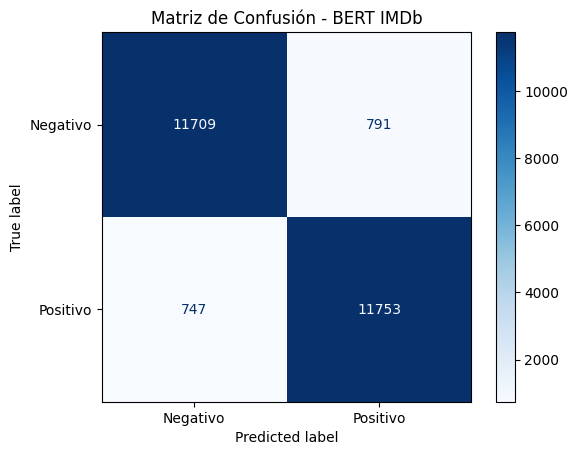

In [9]:
# =========================
# 步骤14（新增）: 混淆矩阵分析
# =========================

# 导入混淆矩阵模块
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 计算混淆矩阵
cm = confusion_matrix(test_labels, bert_preds)

# 打印混淆矩阵数据
print("\nMatriz de confusión (BERT en IMDb):")
print(cm)

# 可视化混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negativo', 'Positivo'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - BERT IMDb")
plt.show()
